In [19]:
from skimage.filters import threshold_local
from PIL import Image,ImageEnhance
import numpy as np 
import cv2
from cv2.typing import MatLike
import matplotlib.pyplot as plt

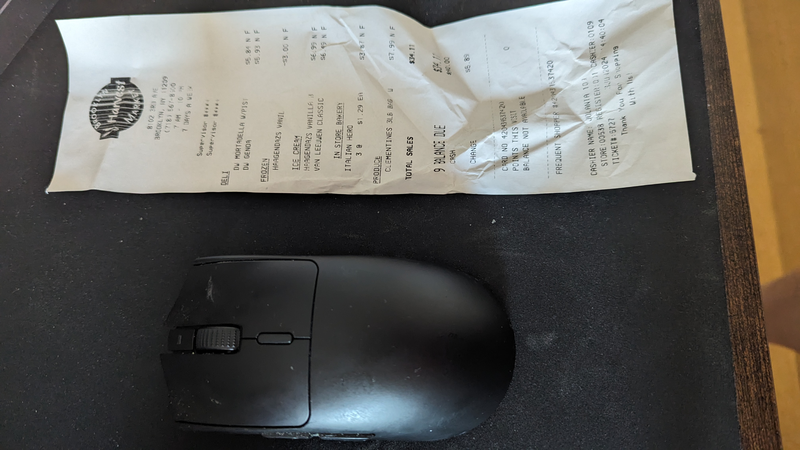

In [20]:
file_name = '../data/origin_img/img_0001.jpg'
img = Image.open(file_name)
img.thumbnail((800,800), Image.LANCZOS)
img

In [21]:
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

In [22]:
image = cv2.imread(file_name)
# Downscale image as finding receipt contour is more efficient on a small image
resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

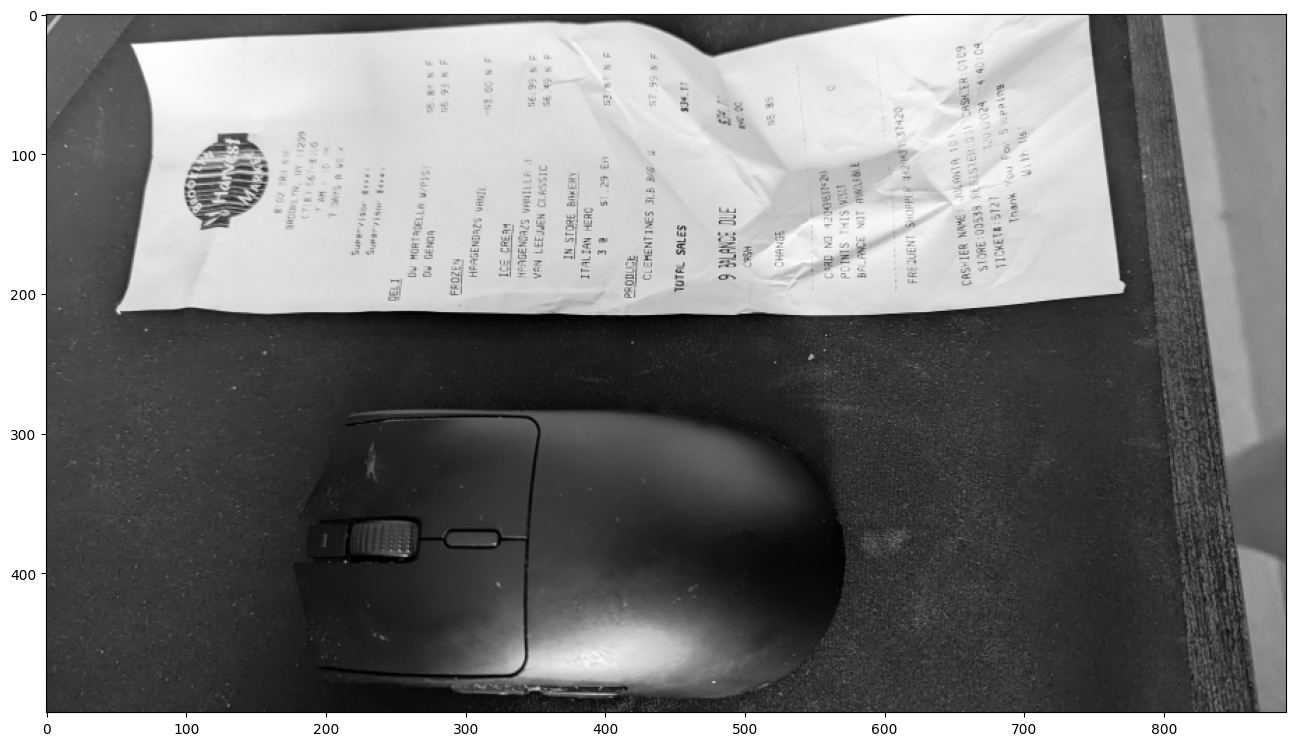

In [23]:
# Convert to grayscale for further processing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray)

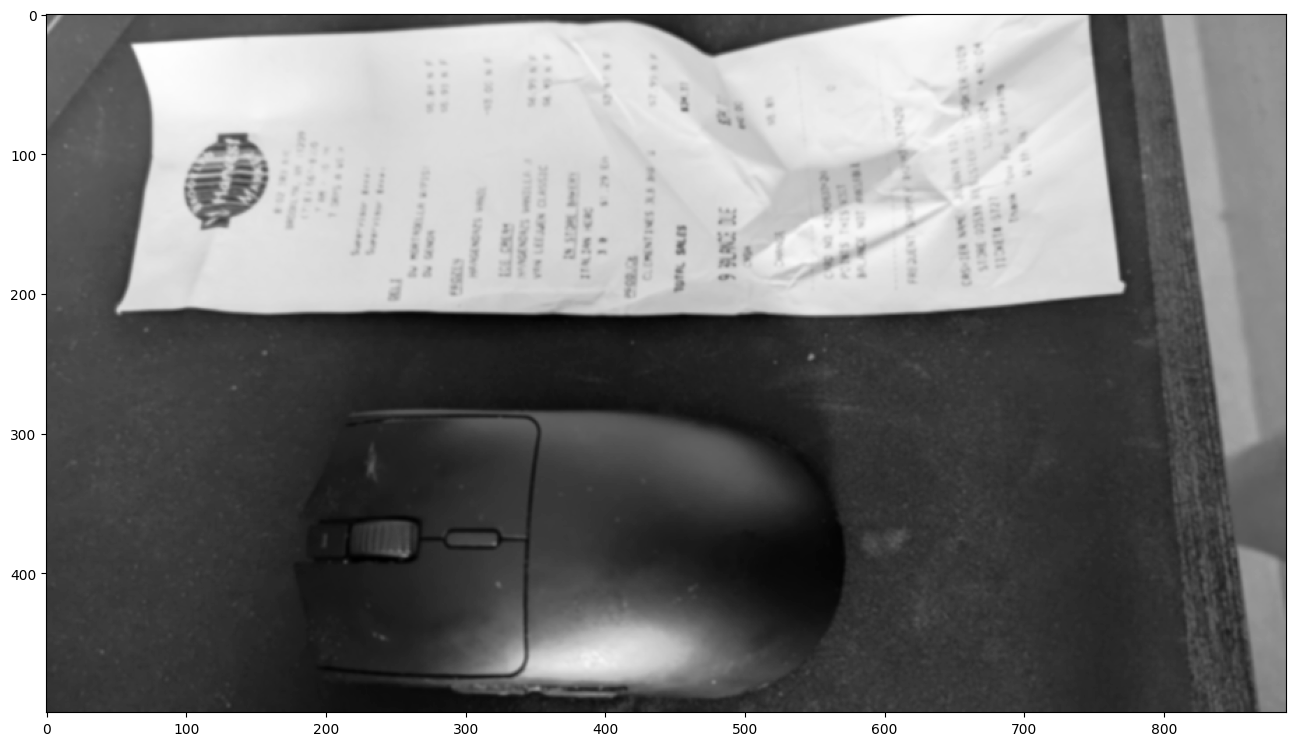

In [24]:
# Get rid of noise with Gaussian Blur filter
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plot_gray(blurred)

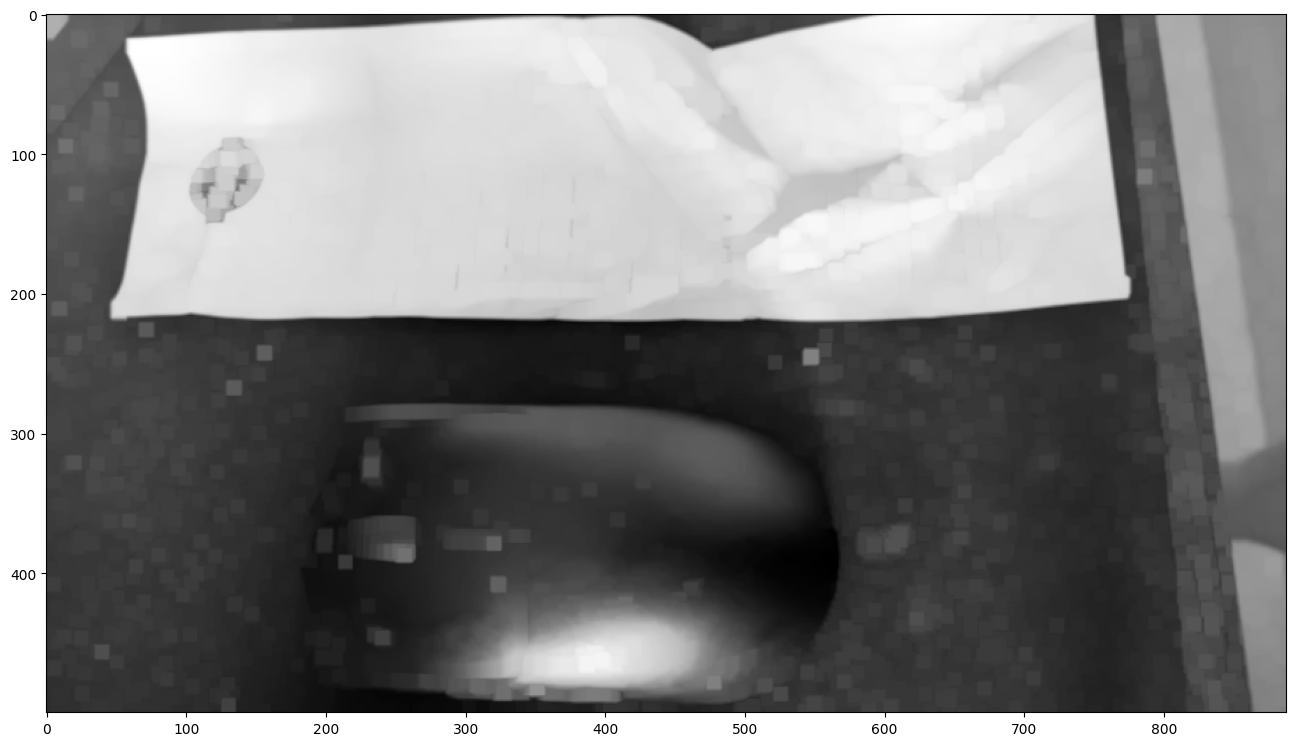

In [25]:
# Detect white regions
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
dilated = cv2.dilate(blurred, rectKernel)
plot_gray(dilated)

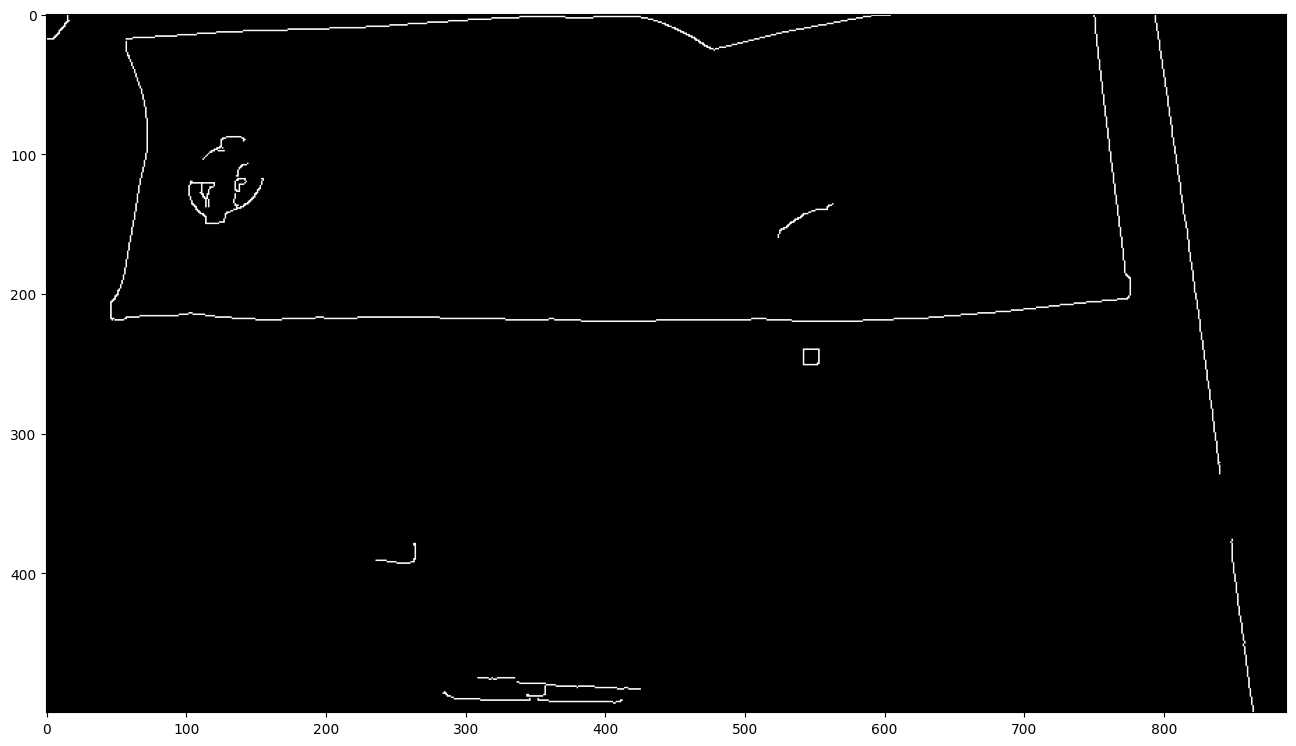

In [26]:
edged = cv2.Canny(dilated, 100, 200, apertureSize=3)
plot_gray(edged)

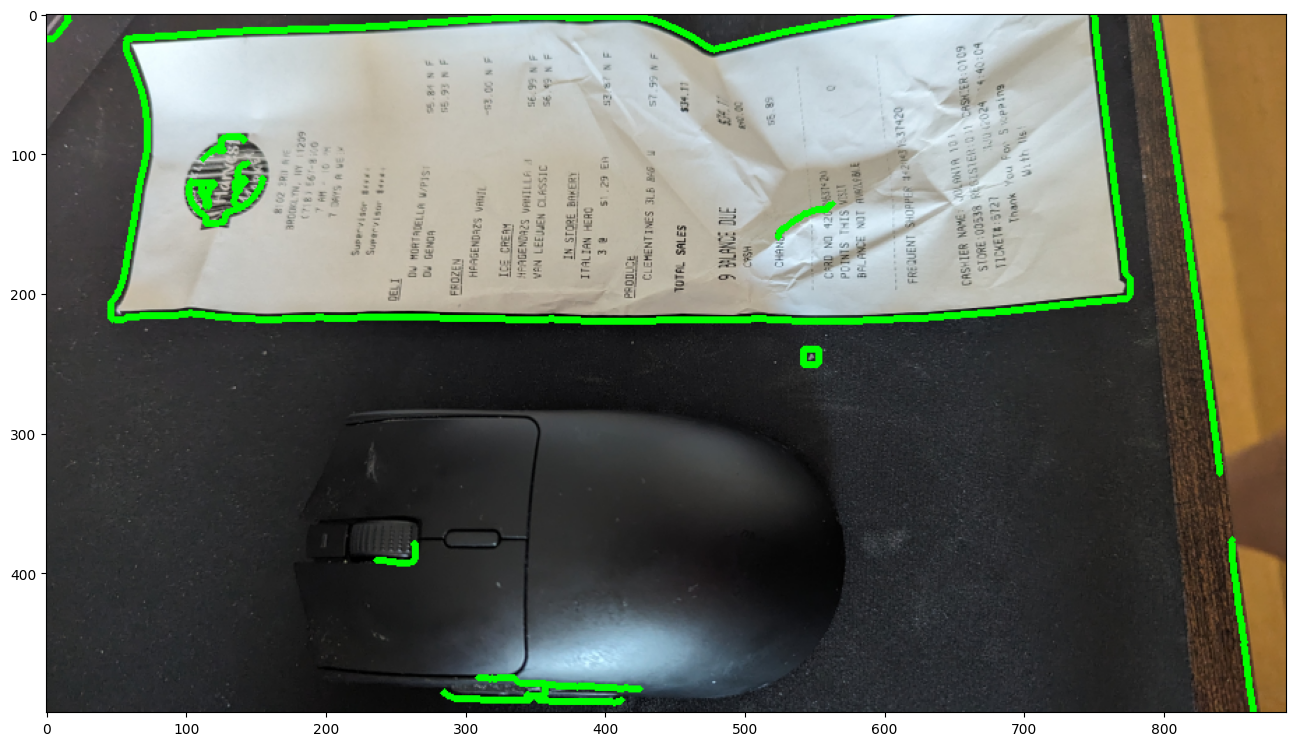

In [27]:
# Detect all contours in Canny-edged image
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

To find the contour of receipt we will make use of two simple heuristics:

- receipt is the largest contour whithin image
- receipt is expected to be of a rectangular shape
We will start with the first heuristic by getting TOP largest contours

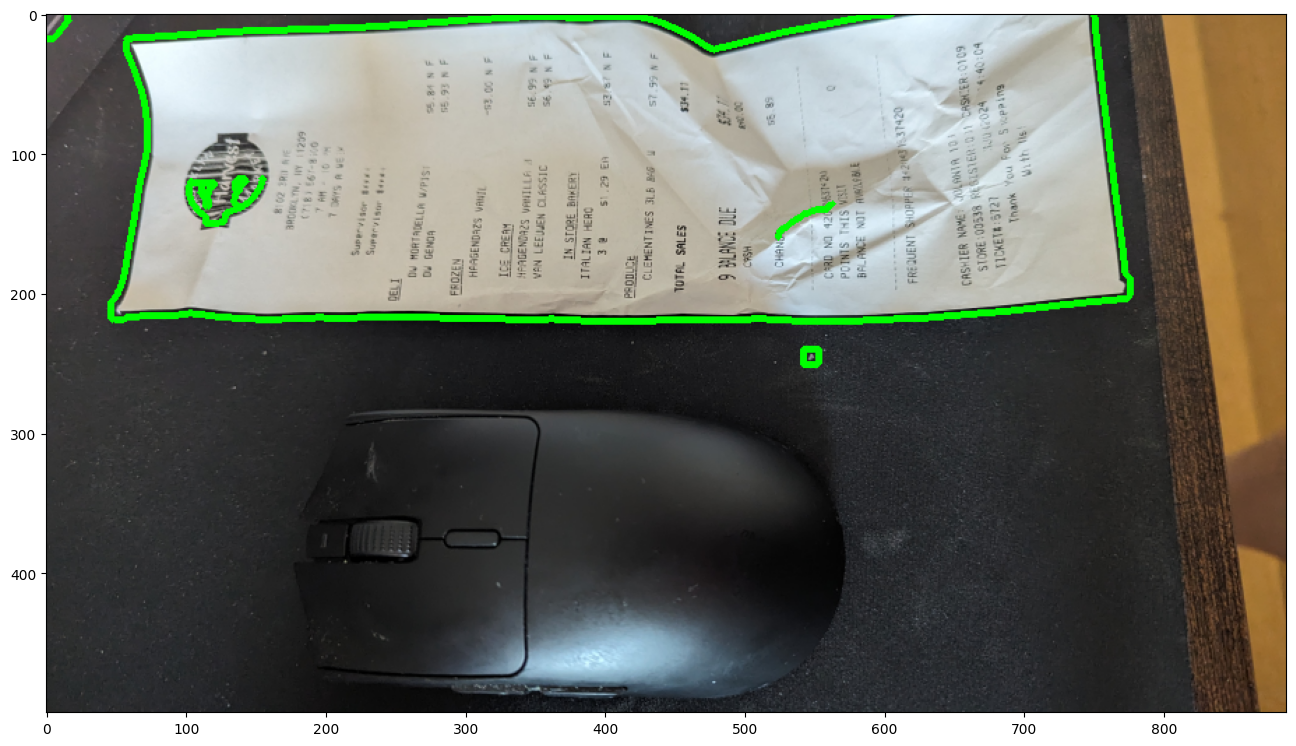

In [28]:
# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

In [29]:
# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)
def get_receipt_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx

In [30]:
get_receipt_contour(largest_contours)

array([[[542, 240]],

       [[542, 251]],

       [[552, 251]],

       [[553, 240]]], dtype=int32)

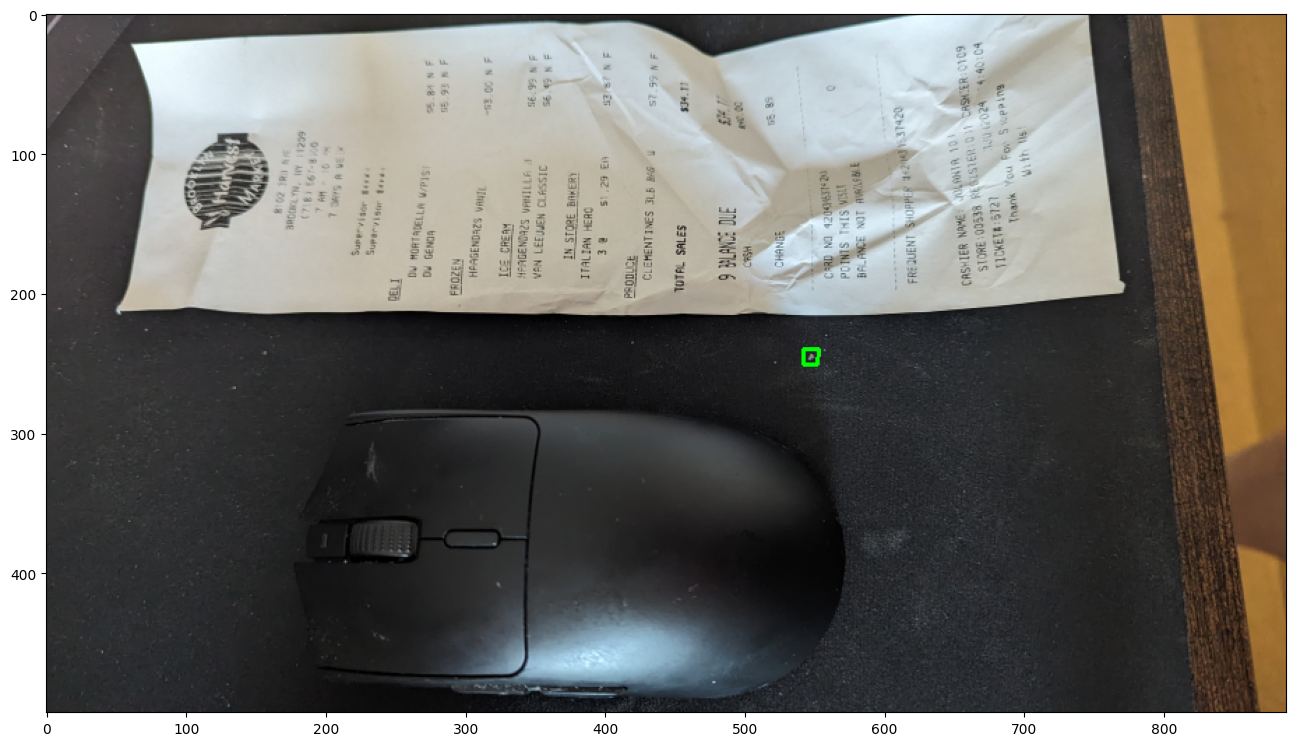

In [31]:
receipt_contour = get_receipt_contour(largest_contours)
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
plot_rgb(image_with_receipt_contour)

In [32]:
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

In [33]:
def wrap_perspective(img, rect) -> MatLike:
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

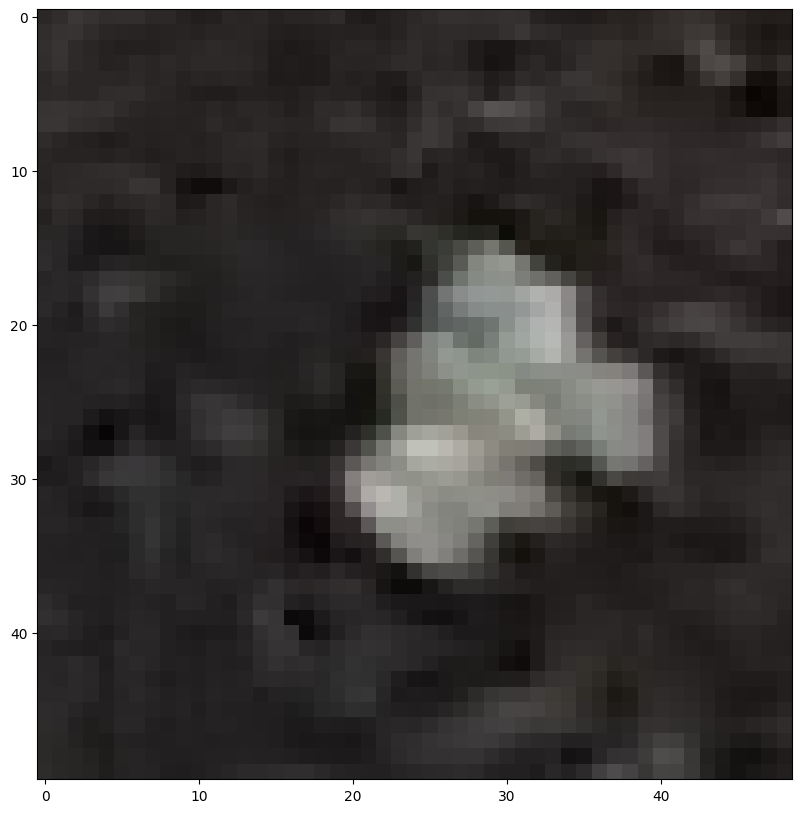

In [34]:
scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
plt.figure(figsize=(16,10))
plt.imshow(scanned)

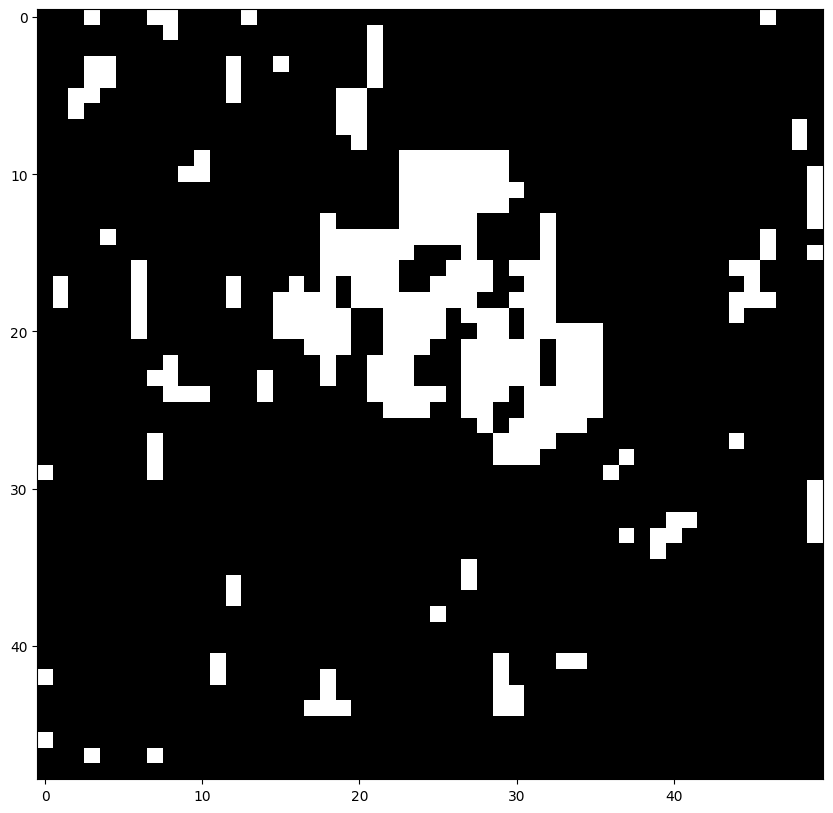

In [35]:
# def gaussian_filter(kernel_size,img,sigma=1, muu=0):
#     x, y = np.meshgrid(np.linspace(-1, 1, kernel_size),
#                        np.linspace(-1, 1, kernel_size))
#     dst = np.sqrt(x**2+y**2)
#     normal = 1/(((2*np.pi)**0.5)*sigma)
#     gauss = np.exp(-((dst-muu)**2 / (2.0 * sigma**2))) * normal
#     gauss = np.pad(gauss, [(0, img.shape[0] - gauss.shape[0]), (0, img.shape[1] - gauss.shape[1])], 'constant')
#     return gauss

# def fft_deblur(image_mat:MatLike, kernel_size, kernel_sigma=5, factor='wiener', const=0.002):
#     # Convert image_mat to grayscale and float32
#     gray = cv2.cvtColor(image_mat, cv2.COLOR_BGR2GRAY)
#     gray = gray.astype(np.float32) / 255.0  # Normalize to [0, 1]
#     gauss = gaussian_filter(kernel_size,gray,kernel_sigma)
#     img_fft = np.fft.fft2(gray)
#     gauss_fft = np.fft.fft2(gauss)
#     weiner_factor = 1 / (1+(const/np.abs(gauss_fft)**2))
#     if factor!='wiener':
#         weiner_factor = factor
#     recon = img_fft/gauss_fft
#     recon*=weiner_factor
#     recon = np.abs(np.fft.ifft2(recon))
#     return recon
# recon = fft_deblur(scanned,7,5,factor='wiener',const=0.6)
# plot_gray(recon)
def bw_scanner(image)-> MatLike:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpen = cv2.filter2D(gray, -1, sharpen_kernel)
    thresh = cv2.threshold(sharpen, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    # T = threshold_local(sharpen, 25, offset = 7, method = "gaussian")
    # return (gray > T).astype("uint8") * 255
    return cv2.bitwise_not(thresh)
result = bw_scanner(scanned)
minval = np.percentile(result, 4.5)
maxval = np.percentile(result, 95)
pixvals = np.clip(result, minval, maxval)
pixvals = ((pixvals - minval) / (maxval - minval)) * 255
result = np.rot90(pixvals.astype(np.uint8),1)
plot_rgb(result)


In [36]:
output = Image.fromarray(result)
output.save('result.png')